### Importing Data Set

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)

data = pd.read_excel('default of credit card clients.xls')

col_names = ['Balance', 'Sex', 'Education', 'Marriage', 'Age',
            'Paid_Sep', 'Paid_Aug', 'Paid_Jul', 'Paid_Jun', 'Paid_May', 'Paid_Apr',
            'Bill_Sep', 'Bill_Aug', 'Bill_Jul', 'Bill_Jun', 'Bill_May', 'Bill_Apr',
            'PayAmt_Sep', 'PayAmt_Aug', 'PayAmt_Jul', 'PayAmt_Jun', 'PayAmt_May', 'PayAmt_Apr',
            'Default']

data.drop(data.index[:1], inplace=True)
data.columns = col_names
data = data.astype(str).astype(int)

### Splitting and Scaling Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Label response and predictors
response = 'Default'
predictors = [x for x in list(data.columns) if x not in response]

# Step 2: Split data set
X_train, X_test, y_train, y_test = train_test_split(data[predictors], data[[response]],
                                                    test_size=0.2, random_state=42)

# Step 3: Prepare for scaling
scaler = StandardScaler().fit(X_train)

# Step 4: Scale the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Baseline Model

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train, np.ravel(y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [4]:
# Score against test set
logit.score(X_test, y_test)

0.80983333333333329

In [5]:
# AUC calculation
from sklearn.metrics import roc_auc_score
y_score = logit.fit(X_train, np.ravel(y_train)).decision_function(X_test)

roc_auc = roc_auc_score(y_test, y_score)
print(roc_auc)

0.726933289741


In [6]:
# ALTERNATIVE AUC calculation
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.726933289741


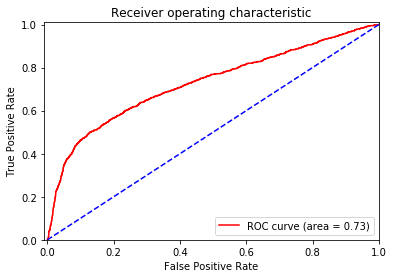

In [25]:
# ROC curve
import matplotlib.pyplot as plt

plt.figure()

plt.plot(fpr, tpr, color='red',
         label='ROC curve (area = {})'.format(roc_auc.round(2)))

plt.plot([0, 1], [0, 1], color='blue', linestyle='--')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

### Confusion matrix stuff

In [32]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = logit.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[4549,  138],
       [1003,  310]], dtype=int64)

In [68]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

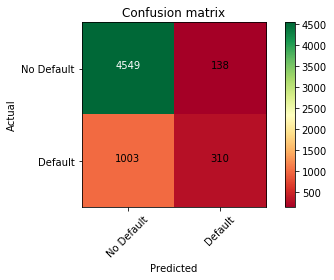

In [104]:
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['No Default','Default']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, cmap=plt.cm.RdYlGn,
                      title='Confusion matrix')
plt.show()

TP: 4549 | FN: 138

FP: 1003 | TN: 310





In [105]:
total = sum(sum(cnf_matrix))

accuracy = (cnf_matrix[0,0]+cnf_matrix[1,1])/total
print ('Accuracy: ', accuracy.round(3))

sensitivity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print('Sensitivity: ', sensitivity.round(3))

specificity = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print('Specificity: ', specificity.round(3))

Accuracy:  0.81
Sensitivity:  0.971
Specificity:  0.236


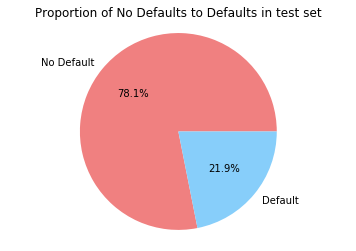

In [99]:
test_ratio = y_test['Default'].value_counts()

# Data to plot
labels = 'No Default', 'Default'
sizes = [test_ratio[0], test_ratio[1]]
colors = ['lightcoral', 'lightskyblue']
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%')
 
plt.axis('equal')
plt.title('Proportion of No Defaults to Defaults in test set')
plt.show()

Basically, we aren't doing any better than guessing...

### OTHER STUFF

In [21]:
# Table of predictions for comparison
y_pred = logit.predict(X_test)

table = pd.DataFrame(y_test)
table['Pred'] = y_pred
table.head()

,Default,Pred
2309,0,0
22405,0,0
23398,0,0
25059,0,0
2665,1,0


Useful links:
1. https://rstudio-pubs-static.s3.amazonaws.com/281390_8a4ea1f1d23043479814ec4a38dbbfd9.html
2. https://www.kaggle.com/lucabasa/credit-card-default-a-very-pedagogical-notebook
3. https://www.kaggle.com/snaveen13/extensive-eda-and-5-classification-algorithm
4. https://sevenpillarsinstitute.org/case-studies/taiwans-credit-card-crisis/ (info on Taiwan Credit Crisis)

BUILD A LOSS MATRIX:

Truth/pred | default | repayment

default | 0 | loss from default

repayment | loss frm dflt | profit

BASELINE MODEL is just going to be treating the problem as business as usual, so that we can compare how much money we save the business from our model

So BASELINE MODEL should just be something like a 50/50 (less naive, but ignorant nonetheless)